In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

project_name = "master-thesis"

interesting_run_names = ["baseline-phcd_paper", "architecture-1-phcd_paper", "architecture-2-phcd_paper", "architecture-7-phcd_paper" ] # "architecture-3-phcd_paper", "architecture-7-phcd_paper"
architectures = ["Bazowa", "Architektura A", "Architektura B", "Architektura C" ]
plot_titles = ["Dokładność architektury bazowej", "Dokładność architektury A", "Dokładność architektury B", "Dokładność architektury C" ]
api = wandb.Api()

# get all runs for a project    
runs = api.runs(f"gratkadlafana/{project_name}")

run_ids = []
all_runs = pd.DataFrame(columns=["run_name", "epoch", "train_accuracy", "train_loss", "val_accuracy", "val_loss"])
test_accuracy = pd.DataFrame(columns=["run_name", "test_accuracy", "test_loss"])
for name in interesting_run_names:
    # get run id
    run_id = [run.id for run in runs if run.name == name and run.state == "finished"][0]
    print(f"Run {name}, id: {run_id}")
    run_ids.append(run_id)
    continue
    for run in runs:
        # add history data to dataframe all_runs
        history = run.history()
         
        if history.get('epoch') is None:
            print(f"Run {name} has no history")
            print(history)
            continue

        new_hist_row = {"run_name": name, "epoch": history["epoch"], "train_accuracy": history["accuracy"], "train_loss": history["loss"], "val_accuracy": history["val_accuracy"], "val_loss": history["val_loss"]}
        all_runs = pd.concat([all_runs, pd.DataFrame(new_hist_row, index=[0])], ignore_index=True)

        # add test data to dataframe test_accuracy
        test = run.summary
        new_row = {"run_name": name, "test_accuracy": test["test_accuracy"], "test_loss": test["test_loss"]}
        test_accuracy = pd.concat([test_accuracy, pd.DataFrame(new_row, index=[0])], ignore_index=True)

Run baseline-phcd_paper, id: 2h1y183m
Run architecture-1-phcd_paper, id: 3of9wiae
Run architecture-2-phcd_paper, id: c09tnm2o
Run architecture-7-phcd_paper, id: n7ho557l


In [13]:
test_accuracy = pd.DataFrame(columns=["run_name", "test_accuracy", "test_loss"])
for name in interesting_run_names:
    for run in runs:
        if run.name != name:
            continue

        # run does not contain tag "article", continue
        if "article" not in run.tags:
            continue

        # add test data to dataframe test_accuracy
        #print(run.__dict__)
        test = run.summary
        if test.get('test_accuracy') is None:
            print(f"Run {name} has no test data")
            print(test)
            continue
        new_row = {"run_name": name, "test_accuracy": test["test_accuracy"], "test_loss": test["test_loss"]}
        test_accuracy = pd.concat([test_accuracy, pd.DataFrame(new_row, index=[0])], ignore_index=True)


test_accuracy['Architektura'] = test_accuracy['run_name'].apply(lambda x: architectures[interesting_run_names.index(x)])
test_accuracy

,run_name,test_accuracy,test_loss,Architektura
0,baseline-phcd_paper,0.857781,0.352473,Bazowa
1,baseline-phcd_paper,0.858785,0.34814,Bazowa
2,baseline-phcd_paper,0.856472,0.354824,Bazowa
3,baseline-phcd_paper,0.858319,0.348277,Bazowa
4,baseline-phcd_paper,0.860793,0.342084,Bazowa
...,...,...,...,...
75,architecture-7-phcd_paper,0.868503,0.450107,Architektura C
76,architecture-7-phcd_paper,0.867768,0.424364,Architektura C
77,architecture-7-phcd_paper,0.874186,0.426216,Architektura C
78,architecture-7-phcd_paper,0.864971,0.444062,Architektura C


In [14]:
test_accuracy['run_name'].value_counts()

baseline-phcd_paper          20
architecture-1-phcd_paper    20
architecture-2-phcd_paper    20
architecture-7-phcd_paper    20
Name: run_name, dtype: int64

In [28]:
for name in interesting_run_names:
    subset = test_accuracy[test_accuracy['run_name'] == name]
    median = subset['test_accuracy'].median()
    std_dev = subset['test_accuracy'].std()
    print(f"Architektura: {name}, Median: {round(median, 4)}, std dev: {round(std_dev, 4)}")

# put it into a dataframe
summary = pd.DataFrame(columns=["run_name", "median test accuracy", "standard deviation"]) 
for name in interesting_run_names:
    subset = test_accuracy[test_accuracy['run_name'] == name]
    median = subset['test_accuracy'].median()
    std_dev = subset['test_accuracy'].std()
    summary = pd.concat([summary, pd.DataFrame({"run_name": name, "median test accuracy": median, "standard deviation": std_dev}, index=[0])], ignore_index=True)

summary.columns = ["Architektura", "Mediana dokładności", "Odchylenie standardowe"]
summary

Architektura: baseline-phcd_paper, Median: 0.8574, std dev: 0.0037
Architektura: architecture-1-phcd_paper, Median: 0.9712, std dev: 0.0037
Architektura: architecture-2-phcd_paper, Median: 0.9487, std dev: 0.0047
Architektura: architecture-7-phcd_paper, Median: 0.8674, std dev: 0.0049


,Architektura,Mediana dokładności,Odchylenie standardowe
0,baseline-phcd_paper,0.857422,0.003732
1,architecture-1-phcd_paper,0.971214,0.003691
2,architecture-2-phcd_paper,0.948685,0.004726
3,architecture-7-phcd_paper,0.867391,0.004937


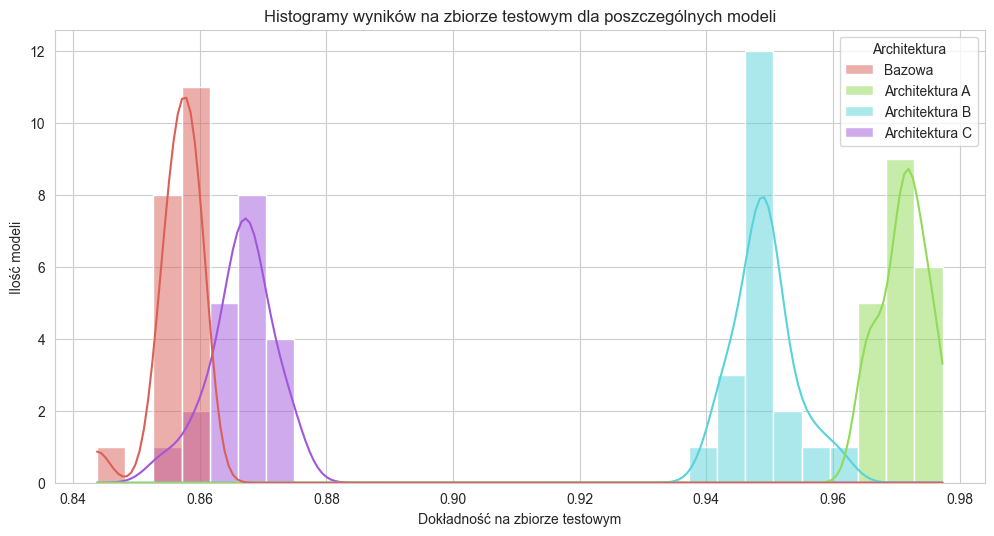

In [33]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.histplot(data=test_accuracy, x="test_accuracy", hue="Architektura", bins=30, kde=True, palette=sns.color_palette("hls", 4), ax=ax, legend=True)

ax.set_title("Histogramy wyników na zbiorze testowym dla poszczególnych modeli")
ax.set_xlabel("Dokładność na zbiorze testowym")
ax.set_ylabel("Ilość modeli")
plt.show()

In [16]:
results_table = pd.DataFrame(columns=["run_name", "test acc", "number of parameters", "GFLOPs", "throughput [images / s]", "compressed disk size [bytes]"])
for run_id, run_name in zip(run_ids, interesting_run_names):
    # for each run get the metrics and save them to the results_table
    run = api.run(f"gratkadlafana/{project_name}/{run_id}")
    metrics = run.summary
    new_row = pd.DataFrame({
        "run_name": run_name,
        "test acc": metrics["test_accuracy"],
        "number of parameters": metrics["num_parameters"],
        "GFLOPs": metrics["model_flops"],
        "throughput [images / s]": metrics["throughput"],
        "compressed disk size [bytes]": metrics["compressed_disk_size"]
    },
    index=[0])
    results_table = pd.concat([results_table, new_row], ignore_index=True)

results_table["compressed disk size [Mb]"] = results_table["compressed disk size [bytes]"].map(lambda x : round(x / 1024 / 1024, 3)) 
results_table["FLOPs (milions)"] = results_table["GFLOPs"].map(lambda x: round(x * 1000, 3))
results_table["number of parameters (thousands)"] = results_table["number of parameters"].map(lambda x : round(x / 1000, 3))
results_table["throughput [thousands of images / s]"] = results_table["throughput [images / s]"].map(lambda x : round(x / 1000, 3))
results_table["label"] = results_table["run_name"].map(lambda x : architectures[interesting_run_names.index(x)])

results_table = results_table[["run_name", "label", "test acc", "number of parameters (thousands)", "FLOPs (milions)", "compressed disk size [Mb]", "throughput [thousands of images / s]"]]
display(results_table)

,run_name,label,test acc,number of parameters (thousands),FLOPs (milions),compressed disk size [Mb],throughput [thousands of images / s]
0,baseline-phcd_paper,Bazowa,0.857781,497.721,14.308,1.785,24.588
1,architecture-1-phcd_paper,Architektura A,0.972298,13831.385,17.223,49.536,27.396
2,architecture-2-phcd_paper,Architektura B,0.94318,1779.161,5.713,6.393,26.708
3,architecture-7-phcd_paper,Architektura C,0.866961,200.729,1.401,0.719,7.434


In [17]:
training_table = pd.DataFrame(columns=["run_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"])
for run_id, run_name in zip(run_ids, interesting_run_names):
    # for each run get the metrics and save them to the results_table
    run = api.run(f"gratkadlafana/{project_name}/{run_id}")
    history = run.history()
    history_df = pd.DataFrame(history)
    history_df["run_name"] = run_name
    training_table = pd.concat([training_table, history_df], ignore_index=True)

display(training_table)

,run_name,epoch,loss,accuracy,val_loss,val_accuracy,_step,_runtime,_timestamp,accuracy_per_class,throughput,model_flops,test_accuracy,num_parameters,compressed_disk_size,test_loss
0,baseline-phcd_paper,0.0,0.854623,0.718939,0.533007,0.800308,0.0,73.000000,1.676048e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,baseline-phcd_paper,1.0,0.60579,0.782245,0.481879,0.81565,1.0,104.000000,1.676048e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,baseline-phcd_paper,2.0,0.565564,0.793265,0.46112,0.821573,2.0,145.000000,1.676048e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,baseline-phcd_paper,3.0,0.543154,0.79991,0.445148,0.826242,3.0,177.000000,1.676048e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,baseline-phcd_paper,4.0,0.529921,0.803711,0.42947,0.830991,4.0,217.000000,1.676048e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,architecture-7-phcd_paper,56.0,0.185264,0.924371,0.434772,0.870367,56.0,4600.422072,1.675876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240,architecture-7-phcd_paper,57.0,0.18496,0.924647,0.443193,0.867078,57.0,4698.929230,1.675876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,architecture-7-phcd_paper,58.0,0.18454,0.925118,0.448122,0.867759,58.0,4795.746146,1.675876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,architecture-7-phcd_paper,59.0,0.182369,0.925863,0.457043,0.866792,59.0,4893.867834,1.675876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
sns.set_style("whitegrid")

ValueError: The palette list has the wrong number of colors.

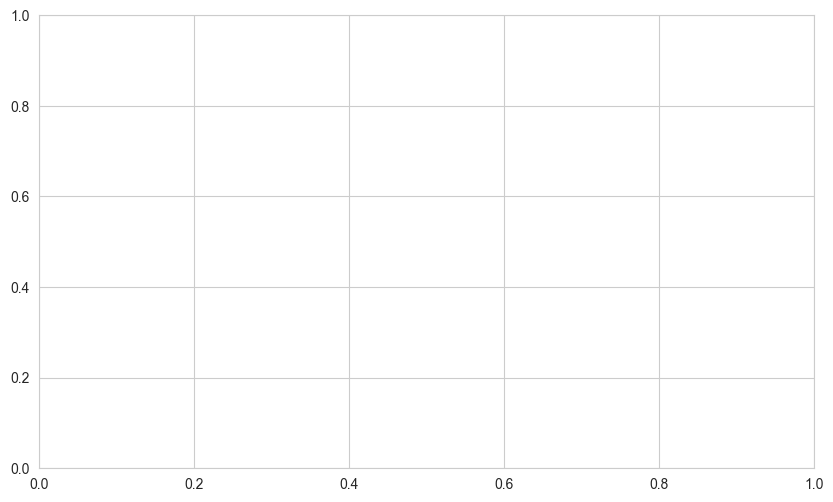

In [19]:
# plot on the same graph accuracy for all architectures, baseline-phcd_paper should be plotted as red dashed line
baseline = training_table[training_table["run_name"] == "baseline-phcd_paper"]
not_baseline = training_table[training_table["run_name"] != "baseline-phcd_paper"]

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.lineplot(data=baseline, x="epoch", y="accuracy", ax=ax, color="black", dashes=True)
sns.lineplot(data=not_baseline, x="epoch", y="accuracy", ax=ax, palette=sns.color_palette("hls", 3), hue="run_name")
ax.lines[0].set_linestyle("--")
ax.lines[0].set_zorder(100)
ax.lines[0].set_linewidth(1)

ax.set_title("Dokładność (mediana) na zbiorze treningowym")
ax.set_xlabel("Epoka")
ax.set_ylabel("Dokładność")
ax.set_ylim(0.7, 1.0)
ax.legend(architectures)
plt.show()
fig.savefig("train_acc.png")

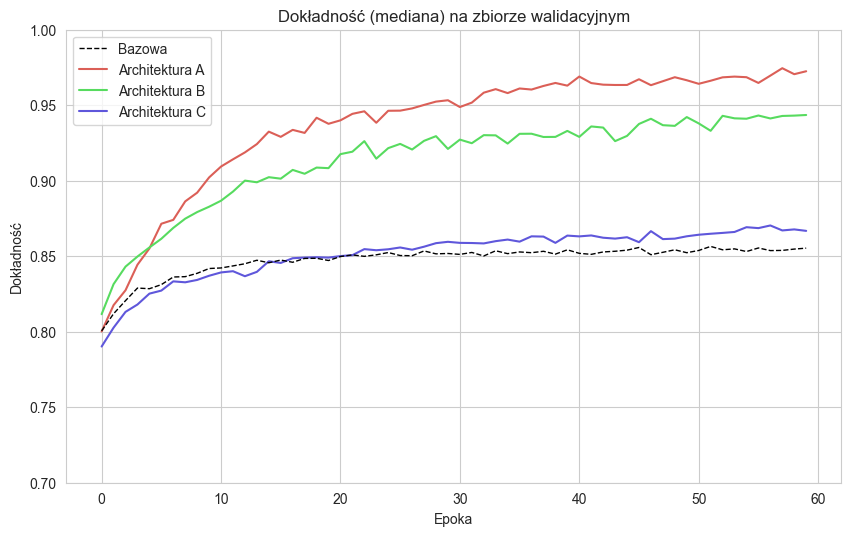

In [ ]:
# plot on the same graph accuracy for all architectures, baseline-phcd_paper should be plotted as red dashed line
baseline = training_table[training_table["run_name"] == "baseline-phcd_paper"]
not_baseline = training_table[training_table["run_name"] != "baseline-phcd_paper"]

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.lineplot(data=baseline, x="epoch", y="val_accuracy", ax=ax, color="black", dashes=True)
sns.lineplot(data=not_baseline, x="epoch", y="val_accuracy", ax=ax, palette=sns.color_palette("hls", 3), hue="run_name")
ax.lines[0].set_linestyle("--")
ax.lines[0].set_zorder(100)
ax.lines[0].set_linewidth(1)

ax.set_title("Dokładność (mediana) na zbiorze walidacyjnym")
ax.set_xlabel("Epoka")
ax.set_ylabel("Dokładność")
# set y axis to range from 0.7 to 1.0
ax.set_ylim(0.7, 1.0)
ax.legend(architectures)
plt.show()
fig.savefig("val_acc.png")

c:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


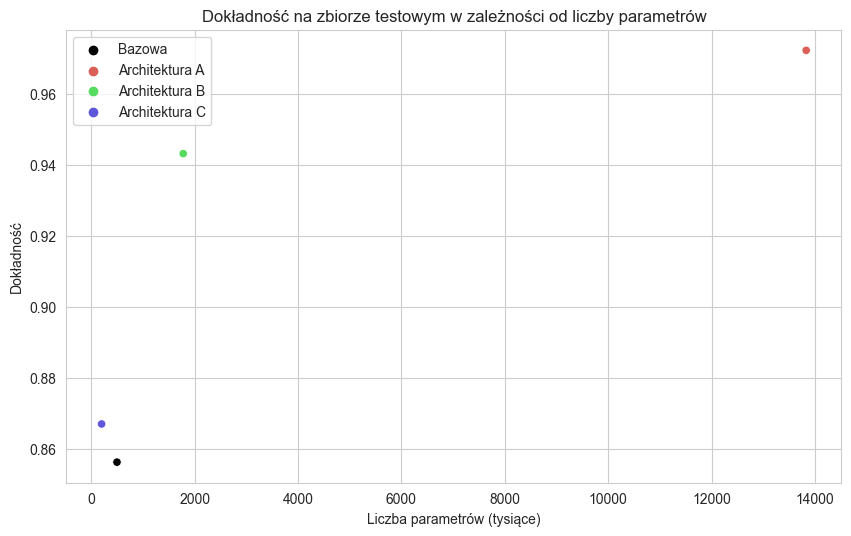

In [ ]:
# palette sns.color_palette("hls", 3) with black added as first
palette = ["black"] + sns.color_palette("hls", 3)

# plot number of parameters vs test accuracy
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
sns.scatterplot(data=results_table, x="number of parameters (thousands)", y="test acc", ax=ax, palette=palette, hue="label")
ax.set_title("Dokładność na zbiorze testowym w zależności od liczby parametrów")
ax.set_xlabel("Liczba parametrów (tysiące)")
ax.set_ylabel("Dokładność")
ax.legend()
plt.show()
fig.savefig("num_params_vs_test_acc.png")